#  LP-model met rating

In [1]:
import pandas as pd
recp = pd.read_csv('/data/foodboost/recipes.csv')
tags = pd.read_csv('/data/foodboost/tags.csv')

# Dataset maken met alles lunch en diner recepten

met receptnaam, tag en aantal calorieën
elk recept heeft nog maar 1 tag (lunch, diner, hoofdgerecht)

In [2]:
tagsmaal= ['lunch','diner','hoofdgerecht']
maaltijd_alles = tags[tags['tag'].str.contains('|'.join(tagsmaal))]
maaltijd_alles=maaltijd_alles.drop_duplicates(subset=['recipe'], keep= 'first')
recp = recp[["title","calories"]]
maaltijd_alles=maaltijd_alles.merge(recp, how="inner" ,right_on= "title",left_on="recipe" ) 
maaltijd_alles = maaltijd_alles[["recipe","tag","calories" ]]

# Random data set maken
Later veranderen in de echte

input is een dictonary met receptnamen en ratings

In [3]:
#from random import randrange
import random

#random dataset maken om de code te controleren
rondom_dict={}
random_rij=[]

while len(rondom_dict)<100:
    random_row= random.randrange(len(maaltijd_alles))
    if random_row not in random_rij:
        rondom_dict[maaltijd_alles.iloc[random_row,0]] = random.randint(1, 5)
        random_rij.append(random_row)

Dataframe met de random recepten

In [4]:
random_maaltijden_df = maaltijd_alles[maaltijd_alles.recipe.isin(list(rondom_dict.keys()))]
df= pd.DataFrame(rondom_dict.items(),columns=['recipe','ratings'])
random_maaltijden_df = random_maaltijden_df.merge(df, how="inner" ,right_on= "recipe",left_on="recipe" ) 
random_maaltijden_df.head()

,recipe,tag,calories,ratings
0,"Romige linguine met brie, artisjok en parmaham",hoofdgerecht,675,5
1,Gegrilde zalm van de BBQ met dillesaus en krie...,hoofdgerecht,790,3
2,"Noedelsoep met kip, spinazie en ei",hoofdgerecht,640,3
3,Spitskoolsoep met prosciuttoperline,hoofdgerecht,420,1
4,Hutspot met gehaktbal,hoofdgerecht,700,2


# Dictonaries maken lunch en diner


In [5]:
random_maaltijden_df_lunch= random_maaltijden_df[random_maaltijden_df["tag"]=="lunch"]
LUNCHES = {row[0]: [row[2], row[3]] for row in random_maaltijden_df_lunch.values}

In [6]:
random_maaltijden_df_diner= random_maaltijden_df[random_maaltijden_df["tag"]!="lunch"]
DINERS = {row[0]: [row[2],row[3]] for row in random_maaltijden_df_diner.values}

# Importeer de benodigde libraries

Importeer pywraplp uit de library ortools.linear_solver 

Importeer matplotlib.pyplot als plt

In [7]:
from ortools.linear_solver import pywraplp
import matplotlib.pyplot as plt

# Definieer de benodigde variabelen

Wij willen voor het gemak 2 keer dezelfde  dictionairy hebben onder een verschillende naam.
Deze dictionairies noemen wij MAALTIJDEN en MAALTIJDEN2.

Ook maken wij een lijst (UNITS) aan met alleen de 'keys' (namen van de gerechten) van de MAALTIJDEN dictionairy en
een lijst (DATA) met de value's (het aantal calorieën van elke maaltijd).

Vervolgens maken wij 2 lijsten aan met alle dagen van de week (DAGEN) en een lijst met de afgekorte versie
van de dagen (DAGPLT) die wij later gaan gebruiken in onze plot.

Als laatste maken wij een dictionairy (AANBEVELING) aan waar de aanbevelingen in komen te staan voor de week 
en een lijst met recourses waar we een paar essentiële waarden in zetten voor de restricties (1040 is het maximaal aantal calorieën per dag en bijde 1en worden gebruikt om het maximaal aantal diners en lunches limiteren tot 1 per dag).

In [8]:
#Definieer de benodigde variabelen
LUNCHES2 = LUNCHES.copy()

DINERS2 = DINERS.copy()

MAALTIJDEN = LUNCHES | DINERS

MAALTIJDEN2 = MAALTIJDEN.copy()

UNITS = list(LUNCHES.keys()) + list(DINERS.keys()) #+ list(LUNCHES_RATING.keys()) + list(DINERS_RATING.keys())

DATA = list(LUNCHES.values()) +  list(DINERS.values())#, + list(LUNCHES_RATING.values()) +list(DINERS_RATING.values())

DAGEN = ['Maandag', 'Dinsdag', 'Woensdag', 'Donderdag', 'Vrijdag', 'Zaterdag', 'Zondag']

DAGPLT = ['Ma', 'Di', 'Wo', 'Do', 'Vr', 'Za', 'Zo']

Kcal = []
Kcal_lunch = []
Kcal_diner = [] 
rating = []
rating_lunch = []
rating_diner = []

AANBEVELING = {}

RESOURCES = [1040, 1, 1, 1, 1]

# Maak het LP model aan

Eerst maken wij een leeg LP model aan en noemen deze solver. Hierin geven wij de naam van ons LP model mee. 
Het tweede onderdeel moet gewoon gekopieerd en geplakt worden.

In stap 1 geven wij aan met welk type variabelen wij in de solver gaan werken. Deze hebben wij op integer 
(Intvar) gezet omdat wij alleen met hele recepten (kunnen) werken. 

In stap 2 worden de restricties toegevoegd aan het model door middel van for loops. De eerste for loop zorgt
ervoor dat alle gekozen recepten niet de maximale caloriegrens van 1040 word overschreden. De tweede for loop
zegt dat er maximaal maar 1 lunchrecept gekozen mag worden en de derde for loop geeft aan dat er maar 1 diner 
gekozen mag worden.

In stap 3 van de solver geven we aan wat onze doelfunctie is en wat ons doel is met de doelfunctie. Ons doel 
is in dit geval om het aandat caloriën zo dicht mogelijk bij de grenswaarde te krijgen van 1040 calorieën, dus 
kiezen wij om de doelfunctie te maximaliseren (Solver.Maximize()).

Vervolgens laten wij het programma zoeken naar de maximale doelfunctie en slaan wij alle gekozen recepten op
in een lijst genaamd keuzelijst. Als de solver geen oplossing kan vinden geeft deze een melding hiervoor en word er niks opgeslagen.

In [9]:
def solve_army(UNITS, DATA, RESOURCES, dag):
  # Create the linear solver using the CBC backend
  solver = pywraplp.Solver('Minimize resource consumption', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

  # 1. Create the variables we want to optimize
  units = [solver.IntVar(0, 1, unit) for unit in UNITS]

  # 2. Add constraints for each resource
  for r in enumerate(RESOURCES):
    solver.Add(sum(DATA[u][0] * units[u] for u, _ in enumerate(units)) <= RESOURCES[0])       #max 1040 kcal
    # solver.Add(sum(DATA[u][0] * units[u] for u, _ in enumerate(units)) >= RESOURCES[3])
    
  for i in range(len(LUNCHES)):
    solver.Add(sum(units[u] for u in range(len(LUNCHES))) <= RESOURCES[1])                    #max 1 lunch
    
  for i in range(len(DINERS)):
    solver.Add(sum(units[u] for u in range(len(LUNCHES), len(MAALTIJDEN))) <= RESOURCES[2])   #max 1 diner
  
#----------------------------------------------------------------------------------------------------
#hoe veel gaan we de rating laten mee tellen?

  # 3. Minimize the objective function
  solver.Maximize(sum((DATA[u][0]+DATA[u][1] * 10 )* units[u] for u, _ in enumerate(units)))

#----------------------------------------------------------------------------------------------------
    
  # Solve problem
  status = solver.Solve()

  # If an optimal solution has been found, print results
  if status == pywraplp.Solver.OPTIMAL:
    for u, _ in enumerate(units):
      if units[u].solution_value() == 1:
          KEUZELIJST.append(units[u].name())
          AANBEVELING[dag] = KEUZELIJST
          MAALTIJDEN.pop(units[u].name())
          # print(KEUZELIJST)
  else:
      print('The solver could not find an optimal solution.')

# Zorg ervoor dat voor alle dagen worden ingedeeld

Zorg ervoor dat de solver 7 keer word aangeroepen om voor elke dag een aanbeveling te kunnen geven.

In [10]:
for i in range(7):
    KEUZELIJST = []
    solve_army(UNITS, DATA, RESOURCES, DAGEN[i])
    UNITS = list(MAALTIJDEN.keys())
    DATA = list(MAALTIJDEN.values())


# Uitprinten van de aanbevelingen

Print voor elke dag de aanbeveling uit voor de lunch, het diner en het totaal aantal 
calorieën van de lunch en het diner.

In [11]:
print()
print("AANBEVELINGEN VOOR DE WEEK:")
print()
for i in range(len(DAGEN)):
    Kcal.append(MAALTIJDEN2[AANBEVELING[DAGEN[i]][0]] + MAALTIJDEN2[AANBEVELING[DAGEN[i]][1]])
    rating.append(MAALTIJDEN2[AANBEVELING[DAGEN[i]][0]][1] + MAALTIJDEN2[AANBEVELING[DAGEN[i]][1]][1])
    
    Kcal_lunch.append(MAALTIJDEN2[AANBEVELING[DAGEN[i]][0]][0])
    Kcal_diner.append(MAALTIJDEN2[AANBEVELING[DAGEN[i]][1]][0])
    rating_lunch.append(MAALTIJDEN2[AANBEVELING[DAGEN[i]][0]][1])
    rating_diner.append(MAALTIJDEN2[AANBEVELING[DAGEN[i]][1]][1])
    
    
    
    print(f"{DAGEN[i]},    LUNCH: {AANBEVELING[DAGEN[i]][0]}")
    print(f"            DINER: {AANBEVELING[DAGEN[i]][1]}")
    print(f"            Kcal:   {MAALTIJDEN2[AANBEVELING[DAGEN[i]][0]][0] + MAALTIJDEN2[AANBEVELING[DAGEN[i]][1]][0]}")
    print(f"            rating:   {MAALTIJDEN2[AANBEVELING[DAGEN[i]][0]][1] + MAALTIJDEN2[AANBEVELING[DAGEN[i]][1]][1]}")
    


AANBEVELINGEN VOOR DE WEEK:

Maandag,    LUNCH: Kikkererwten-tonijnsalade met venkel &amp; sperziebonen
            DINER: Romige linguine met brie, artisjok en parmaham
            Kcal:   1040
            rating:   9
Dinsdag,    LUNCH: Taleggiotosti
            DINER: Aardappelsalade met bietjes en zalm
            Kcal:   1040
            rating:   9
Woensdag,    LUNCH: Bonensalade
            DINER: Ketjapkip met rabarber
            Kcal:   1040
            rating:   8
Donderdag,    LUNCH: Visburger
            DINER: Stoofvis met salami en paprika
            Kcal:   1020
            rating:   10
Vrijdag,    LUNCH: Omeletwraps
            DINER: Quesadilla's met salsa
            Kcal:   1040
            rating:   8
Zaterdag,    LUNCH: Gegrilde-preisoep met zalm
            DINER: Knapperige oosterse rijst met vega kipstukjes
            Kcal:   1030
            rating:   10
Zondag,    LUNCH: Open sandwich met appel, kaneel en amandel
            DINER: Kip en cranberrycompote
 

# Maak een plot van het totaal aantal ingedeelde calorieën

Eerst worden font1 en font2 toegekent. Hierin staat de betreffende font die we willen gebruiken ('family'), de kleur van de tekst ('color'), de dikte van de text ('weight') en de groote van het lettertype ('size'). font1 wordt hier gebruikt voor de titel en font2 wordt gebruikt voor de namen van de assen.

Als tweede wort er een barplot gemaakt en hiervan worden de kleur bepaald, en de naam van de assen en de titel.

Als laatste word de plot laten zien van het programma.

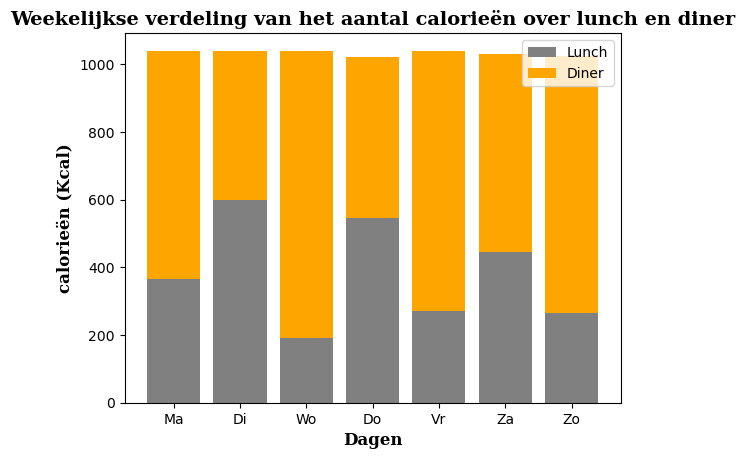

In [12]:
font1 = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 14,
        }

font2 = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }

plt.bar(DAGPLT, Kcal_lunch, color='grey', linewidth = 1.5)
plt.bar(DAGPLT, Kcal_diner, bottom=Kcal_lunch, color='orange')
plt.xlabel('Dagen', fontdict = font2)
plt.ylabel('calorieën (Kcal)', fontdict = font2)
plt.title("Weekelijkse verdeling van het aantal calorieën over lunch en diner", fontdict = font1)
plt.legend(["Lunch", "Diner"])
plt.show()
#Figuur.savefig('Kcal_verloop_per_week_V2.jpeg', dpi = 100)

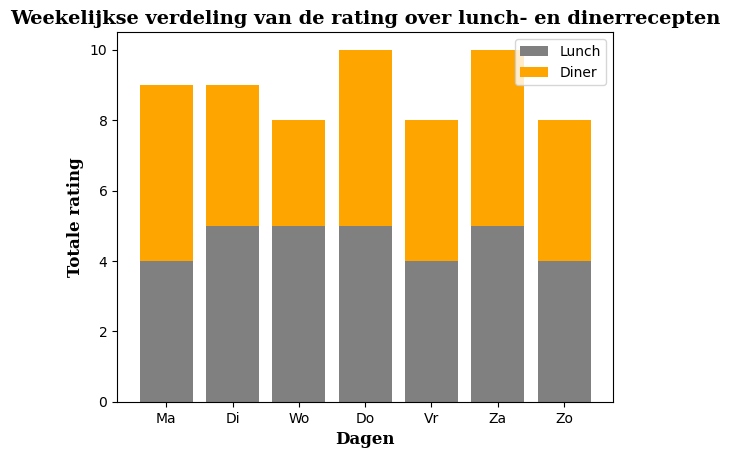

In [13]:
font1 = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 14,
        }

font2 = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }

plt.bar(DAGPLT, rating_lunch, color = 'grey', linewidth = 1.5)
plt.bar(DAGPLT, rating_diner, bottom = rating_lunch, color = 'orange')
plt.xlabel('Dagen', fontdict = font2)
plt.ylabel('Totale rating', fontdict = font2)
plt.title("Weekelijkse verdeling van de rating over lunch- en dinerrecepten", fontdict = font1)
plt.legend(["Lunch", "Diner"])
plt.show()
#Figuur.savefig('rating_verloop_per_week_V2.jpeg', dpi = 100)